### Capstone I
**Goal:** The goal of this project is to identify how to better detect those at risk for suicide. I will be comparing the performance of different classification algorithms by training several models (Naive Bayes, Logistic Regression, and Decision Trees) to detect suicide ideation from social media posts. After comparing model performance, we will further scrutinize the models to identify the features and parameters which most effectively predict whether a user is at risk for suicide.

**Data**

The data is sourced from Kaggle 


link: https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch 
- The data are a collection of posts collected from the 'SuicideWatch' and 'teenagers' subreddits from the Reddit platform using PushshiftAPI. Posts were created between 16 December 2008 - 2 January 2021
- Social media posts collected from the 'SuicideWatch' subreddit are labelled 'suicide', while posts collected from 'teenagers' are labelled 'non-suicide'

#### Import and Setup

In [4]:
import nltk
import time
import string
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords 
from nltk import word_tokenize, sent_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
sns.set_style("whitegrid")
sns.set_palette("rocket")
warnings.simplefilter(action='ignore')

In [ ]:
#import eli5

In [28]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/lois/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lois/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/lois/nltk_data...


True

#### Overview 

**Data Problem**: The data task is to train and tune multiple binary text classification models to group social media posts into suicidal vs non-suicidal classes. Models with high accuracy will be used to predict, from future/unseen posts, whether their writer is at risk for suicide. Further scrutinizing the most important features and parameters which compose the best model will indicate better ways to detect suicide risk. 




**Data Overview** 
- No missing values in the data
- 232074 samples/rows 
- 3 columns: 
       1. Unnamed: 0: A unique ID for each row 
       2. text: Content of the social media post
       3. class: Whether the poster is suicidal or not; values: ['suicide', 'non-suicide']

In [7]:
suicide = pd.read_csv("/Users/Lois/Downloads/ML ipynb/Capstone/SuicideDetection.csv")

In [8]:
print(suicide.shape)
suicide.head()

(232074, 3)


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [9]:
#using a random sample of 20,000 entries for model training
suicide = suicide.sample(20000, random_state = 42)

In [10]:
#sample suicidal post
print('Class:', suicide['class'].iloc[0])
suicide['text'].iloc[0]

Class: suicide


"I Don't know?7? Months self harm free and the urge just gets stronger and stronger every day. The past few days I've just been shit... \nMy family stresses me out especially my nephew (he's 12) My mum has full custody of him and he's told me to go kill myself numerous times.. I wish it was that easy.\nMy partners family stresses me out especially over the past few days. \nStress is my trigger \nI just want to scream and cry. \nI live near the woods so I could go out and scream till I can't possibly scream anymore but the cops will probably get called...\nMy OH knows about my depression but he doesn't really know how I'm feeling at the moment. He would want to come over and make sure I'm OK but he's fucking annoying. He annoys me all the time by doing small stupid things. \nI don't even know where I'm going with the post? \n\n"

In [11]:
#sample non-suicidal post
print('Class:', suicide['class'].iloc[1])
suicide['text'].iloc[1]

Class: non-suicide


'I HAVE TO START BECOMING RICH I HAVE TO START MY COMPANY SO WHEN I BECOME 16 I CAN AFFORD A BIG VAN AND GO ON TRIPS WITH MY FRIENDS BUT I HAVE NO TIME LEFT I HAVE TO START WORKING'

#### Exploratory Data Analysis

In [12]:
suicide.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 74414 to 89712
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20000 non-null  int64 
 1   text        20000 non-null  object
 2   class       20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 625.0+ KB


In [13]:
#no null values
suicide.isna().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

In [14]:
#summary statistics
suicide['char_count'] = suicide.text.apply(len)
print('Mean character count:', suicide['char_count'].mean())
print('Min character count:', suicide['char_count'].min())
print('Max character count:', suicide['char_count'].max())

Mean character count: 680.14645
Min character count: 7
Max character count: 40106


(0.0, 10000.0)

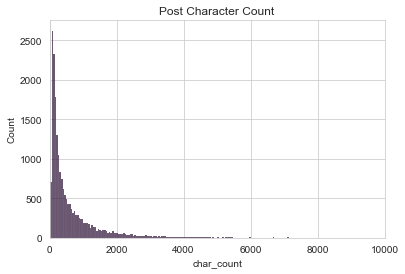

In [15]:
#character count visualization
fig, ax = plt.subplots()
sns.histplot(suicide['char_count'], ax = ax).set_title('Post Character Count')
ax.set_xlim(0, 10000)

In [16]:
#most frequent words in both classes 
suicide_words = list(suicide[suicide['class'] == 'suicide'].text.values)
non_suicide_words = list(suicide[suicide['class'] == 'non-suicide'].text.values)

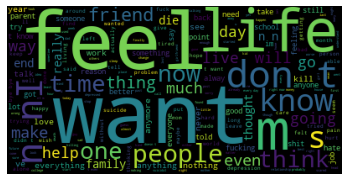

In [17]:
#suicide word cloud 
s_wordcloud = WordCloud(stopwords = STOPWORDS).generate(str(suicide_words))
plt.imshow(s_wordcloud)
plt.axis('off')
plt.show()

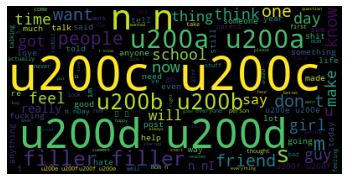

In [18]:
#non-suicide word cloud 
x_wordcloud = WordCloud(stopwords = STOPWORDS).generate(str(non_suicide_words))
plt.imshow(x_wordcloud)
plt.axis('off')
plt.show()

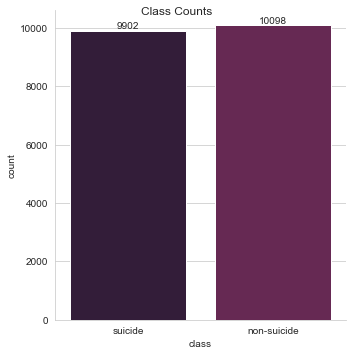

In [19]:
#checking class distribution 
#the data is balanced: Comparable counts of suicide vs non-suicide posts

fig = sns.catplot(x = 'class', kind = 'count', data = suicide)
fig.fig.suptitle("Class Counts")
for fig in fig.axes.flat:
    fig.bar_label(fig.containers[0])

#### Data Setup

In [20]:
#only keeping the text and class columns
suicide.drop("Unnamed: 0", axis = 1, inplace = True)

#renaming "class" column as "suicide"
suicide.rename({"class" : "suicide"}, axis = 1, inplace = True)

#numerically representing the contents of "suicide" column
suicide.replace({"suicide" : 1, "non-suicide" : 0}, inplace = True)
suicide.head()

,text,suicide,char_count
74414,I Don't know?7? Months self harm free and the ...,1,828
149516,I HAVE TO START BECOMING RICH I HAVE TO START ...,0,179
12484,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",0,96
14043,I've honestly got no idea what to do anymore.I...,1,1089
30673,Do you ever just cry? Like you just think abou...,0,268


In [21]:
#train test split
X = suicide['text']
y = suicide['suicide']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#### Text Preprocessing

In [51]:
#tokenization, stop word removal, lower casing 
def preprocess_text(text):
    tokenizer = TweetTokenizer(preserve_case = False)
    swords = stopwords.words('english')
    
    proprocessed_text = []
    for entry in text:
        tokens = tokenizer.tokenize(entry)
        proprocessed_text.append([word for word in tokens if word not in swords])
    return proprocessed_text

In [71]:
pX_train = preprocess_text(X_train)

In [104]:
pX_test = preprocess_text(X_test)

In [106]:
#checking output 
pX_train[0]

['first',
 'gun',
 'last',
 'gunbuying',
 'first',
 'gun',
 'tomorrow',
 '.',
 'problems',
 '.',
 'hopefully',
 'get',
 'courage',
 'use',
 'next',
 'couple',
 'days',
 '.',
 'overdoses',
 '.',
 'medical',
 'bills',
 '.']

In [98]:
#converting back to a list of strings 
X_train = [' '.join(x) for x in pX_train]

In [99]:
#checking output
X_train[0]

'first gun last gunbuying first gun tomorrow . problems . hopefully get courage use next couple days . overdoses . medical bills .'

#### Feature Engineering 
TF-IDF on lemmatized words

In [100]:
lem = WordNetLemmatizer()
analyzer = TfidfVectorizer(lowercase = False).build_analyzer()

def lemmatizer(text):
    return (lem.lemmatize(w) for w in analyzer(text))

In [101]:
#grid search dict

tf_params = {'tfidf__max_features': [1000, 2000, 3000],
            'tfidf__analyzer' : ['word', lemmatizer]}

#### Model Comparison
We will be evaluating the models with the accuracy score metric because we have a balanced dataset. Accuracy measures the proportion of correctly predicted observations out of total observations and is calculated as (True Positive count + True Negative count) / (Total count), or

$$
\frac{TP + TN}{TP + TN + FP + FN}
$$


Holdout cross validation is implemented; models will be trained on the training set and validated with the test set.



**Naïve Bayes** 

In [102]:
#nb + tfidf 
nb_tf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase = False)),
    ('bayes', MultinomialNB())
])

In [108]:
#gridsearch max features 
nb_tf_grid = RandomizedSearchCV(estimator = nb_tf,
                   param_distributions = tf_params)

#fit
start = time.time()
nb_tf_grid.fit(X_train, y_train)
stop = time.time()

#stats
nb_tf_time = stop - start
nb_tf_acc = nb_tf_grid.score(X_test, y_test)
nb_tf_params = nb_tf_grid.best_params_

**Logistic Regression**

In [111]:
#logreg + tfidf 
lgr_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lgr', LogisticRegression())
])

#gridsearch max features 
lgr_tf_grid = RandomizedSearchCV(estimator = lgr_tf,
                   param_distributions = tf_params)

#fit
start = time.time()
lgr_tf_grid.fit(X_train, y_train)
stop = time.time()

#stats
lgr_tf_time = stop - start
lgr_tf_acc = lgr_tf_grid.score(X_test, y_test)
lgr_tf_params = lgr_tf_grid.best_params_

In [112]:
lgr_tf_acc

0.8963333333333333

**Decision Tree**

In [113]:
#dtree + tfidf 
tree_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('dtree', DecisionTreeClassifier())
])

#gridsearch max features 
tree_tf_grid = RandomizedSearchCV(estimator = tree_tf,
                   param_distributions = tf_params)

#fit
start = time.time()
tree_tf_grid.fit(X_train, y_train)
stop = time.time()

#stats
tree_tf_time = stop - start
tree_tf_acc = tree_tf_grid.score(X_test, y_test)
tree_tf_params = tree_tf_grid.best_params_

In [116]:
tree_tf_acc

0.774

In [119]:
#svc
svc_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())
])

#gridsearch max features 
svc_tf_grid = RandomizedSearchCV(estimator = svc_tf,
                   param_distributions = tf_params)

#fit
start = time.time()
svc_tf_grid.fit(X_train, y_train)
stop = time.time()

#stats
svc_tf_time = stop - start
svc_tf_acc = svc_tf_grid.score(X_test, y_test)
svc_tf_params = svc_tf_grid.best_params_

## HERE

In [120]:
svc_tf_acc

0.8856666666666667

In [121]:
#knn
knn_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

#gridsearch max features 
knn_tf_grid = RandomizedSearchCV(estimator = knn_tf,
                   param_distributions = tf_params)

#fit
start = time.time()
knn_tf_grid.fit(X_train, y_train)
stop = time.time()

#stats
knn_tf_time = stop - start
knn_tf_acc = knn_tf_grid.score(X_test, y_test)
knn_tf_params = knn_tf_grid.best_params_

In [122]:
knn_tf_acc

0.512

**Results**

Logistic Regression models have the highest accuracy score, followed by the Naive Bayes and Decision Tree models. 

The model with the highest accuracy score is **Logistic Regression + TF-IDF** with a score of 0.918.

In [115]:
#build df 
'''
stem_df = pd.DataFrame({'model': ['Logistic + CountVectorizer', 'Logistic + Tfidf', 'Decision Tree + CountVectorizer', 'Decision Tree + Tfidf', 'Bayes + CountVectorizer', 'Bayes + Tfidf'], 
              'speed' : [lgr_cv_time, lgr_tf_time, tree_cv_time, tree_tf_time, nb_cv_time, nb_tf_time],
              'best_params': [lgr_cv_params, lgr_tf_params, tree_cv_params, tree_tf_params, nb_cv_params, nb_tf_params],
              'best_score': [lgr_cv_acc, lgr_tf_acc, tree_cv_acc, tree_tf_acc, nb_cv_acc, nb_tf_acc]}).set_index('model')
'''

"\nstem_df = pd.DataFrame({'model': ['Logistic + CountVectorizer', 'Logistic + Tfidf', 'Decision Tree + CountVectorizer', 'Decision Tree + Tfidf', 'Bayes + CountVectorizer', 'Bayes + Tfidf'], \n              'speed' : [lgr_cv_time, lgr_tf_time, tree_cv_time, tree_tf_time, nb_cv_time, nb_tf_time],\n              'best_params': [lgr_cv_params, lgr_tf_params, tree_cv_params, tree_tf_params, nb_cv_params, nb_tf_params],\n              'best_score': [lgr_cv_acc, lgr_tf_acc, tree_cv_acc, tree_tf_acc, nb_cv_acc, nb_tf_acc]}).set_index('model')\n"

In [117]:
#build df 
lem_df = pd.DataFrame({'model': ['Logistic', 'Decision Tree', 'Bayes'], 
              'speed' : [lgr_tf_time, tree_tf_time, nb_tf_time],
              'best_params': [lgr_tf_params, tree_tf_params, nb_tf_params],
              'best_score': [lgr_tf_acc, tree_tf_acc, nb_tf_acc]}).set_index('model')

In [118]:
lem_df

,speed,best_params,best_score
model,,,
Logistic,66.071181,"{'tfidf__max_features': 3000, 'tfidf__analyzer...",0.896333
Decision Tree,143.554728,"{'tfidf__max_features': 3000, 'tfidf__analyzer...",0.774000
Bayes,62.889879,"{'tfidf__max_features': 3000, 'tfidf__analyzer...",0.812167


In [353]:
#stem_df

,speed,best_params,best_score
model,,,
Logistic + CountVectorizer,1260.637436,"{'cv__stop_words': None, 'cv__max_features': 2...",0.909833
Logistic + Tfidf,2640.974808,"{'tfidf__stop_words': None, 'tfidf__max_featur...",0.918333
Decision Tree + CountVectorizer,3147.673905,"{'cv__stop_words': 'english', 'cv__max_feature...",0.817333
Decision Tree + Tfidf,2155.145674,"{'tfidf__stop_words': 'english', 'tfidf__max_f...",0.811833
Bayes + CountVectorizer,929.515114,"{'cv__stop_words': 'english', 'cv__max_feature...",0.888500
Bayes + Tfidf,2868.851403,"{'tfidf__stop_words': None, 'tfidf__max_featur...",0.891333


**Best model parameters**

For every model, the optimal number of max features is 2000; it is likely that a higher number of max features would result in better accuracy. Additionally, there is a clear split on whether stop word removal is necessary. 

- For the Logistic Regression models 
    - No stop word removal 
    - Max features = 2000
- For Decision Tree models
    - Stop word removal
    - Max features = 2000
- For Naive Bayes models
    - Bag-of-Words + stop word removal
    - TF-IDF + no stop word removal
    - Max features = 2000
    

In [358]:
#closer look at params
print(f"lgr + cv: {lgr_cv_params}")
print(f"lgr + tfidf: {lgr_cv_params}")
print(f"dtree + cv: {tree_cv_params}")
print(f"dtree + tfidf: {tree_tf_params}")
print(f"nb + cv: {nb_cv_params}")
print(f"nb + tfidf: {nb_tf_params}")

lgr + cv: {'cv__stop_words': None, 'cv__max_features': 2000, 'cv__analyzer': <function stem at 0x7fd4af3a99d0>}
lgr + tfidf: {'cv__stop_words': None, 'cv__max_features': 2000, 'cv__analyzer': <function stem at 0x7fd4af3a99d0>}
dtree + cv: {'cv__stop_words': 'english', 'cv__max_features': 2000, 'cv__analyzer': 'word'}
dtree + tfidf: {'tfidf__stop_words': 'english', 'tfidf__max_features': 2000, 'tfidf__analyzer': 'word'}
nb + cv: {'cv__stop_words': 'english', 'cv__max_features': 2000, 'cv__analyzer': <function stem at 0x7fd4af3a99d0>}
nb + tfidf: {'tfidf__stop_words': None, 'tfidf__max_features': 2000, 'tfidf__analyzer': <function stem at 0x7fd4af3a99d0>}


#### Comparing Confusion Matrices
Confusion matrices indicate the counts of the type of error each model made in the classification task. In these plots, 0 = not suicidal and 1 = suicidal. 
- The Logistic Regression model has more false negatives than false positives 
- The Naive Bayes model has a more false positives than false negatives
- The Decision Tree model has similar FP and FN counts with slightly more false positives 

In [363]:
#preds
log_preds = lgr_tf_grid.predict(X_test)
nb_preds = nb_tf_grid.predict(X_test)
tree_preds = tree_cv_grid.predict(X_test)

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

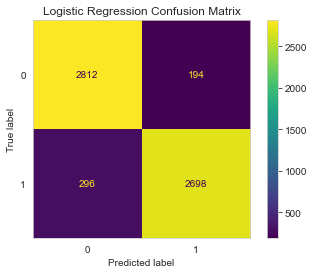

In [366]:
#logreg 
ConfusionMatrixDisplay(confusion_matrix(y_test, log_preds)).plot()
plt.grid(False)
plt.title("Logistic Regression Confusion Matrix")

Text(0.5, 1.0, 'Naive Bayes Confusion Matrix')

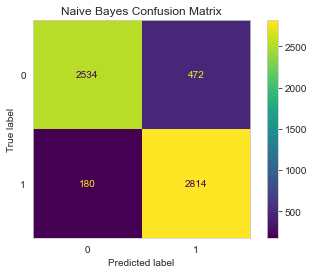

In [367]:
#naive bayes
ConfusionMatrixDisplay(confusion_matrix(y_test, nb_preds)).plot()
plt.grid(False)
plt.title("Naive Bayes Confusion Matrix")

Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

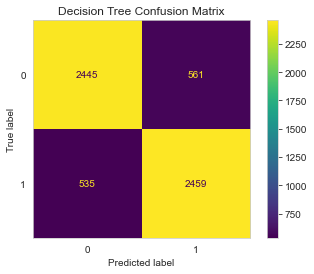

In [369]:
#decision tree
ConfusionMatrixDisplay(confusion_matrix(y_test, tree_preds)).plot()
plt.grid(False)
plt.title("Decision Tree Confusion Matrix")

#### Logistic Regression Model Interpretation 

In [ ]:
#permutation importande 

In [371]:
eli5.show_weights(clf, top=10)

ModuleNotFoundError: No module named 'eli5'

In [ ]:
eli5.show_weights(clf, vec=vec, top=10,
                  target_names=twenty_test.target_names)

In [ ]:
for pipeline in pipelines:
    print('Estimator: %s' % (pipeline['name']))
    labels = pipeline['pipeline'].classes_.tolist()
    
    if pipeline['name'] in ['Logistic Regression', 'Random Forest']:
        estimator = pipeline['pipeline']
    elif pipeline['name'] == 'XGBoost Classifier':
        estimator = pipeline['pipeline'].steps[1][1].get_booster()
#     Not support Keras
#     elif pipeline['name'] == 'keras':
#         estimator = pipeline['pipeline']
    else:
        continue
    
    IPython.display.display(
        eli5.show_weights(estimator=estimator, top=10,
        target_names=labels, vec=vec))